In [1]:
import asyncio
import time

import awkward as ak
from coffea.processor import servicex
from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT
import hist
import matplotlib.pyplot as plt
from servicex import ServiceXDataset

Configuration options: enable / disable `dask` and the use of caching with `ServiceX` (to force re-running transforms).

In [2]:
# enable Dask
USE_DASK = False

# ServiceX behavior: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = True

The processor used here: select jets with $p_T > 25$ GeV and calculate $\textrm{H}_\textrm{T}^{\textrm{had}}$ (scalar sum of jet $p_T$) as observable.

In [3]:
class TtbarAnalysis(servicex.Analysis):
    def __init__(self):
        self.hist = hist.Hist.new.Reg(50, 0, 1000, name="ht", label="HT").Weight()

    def process(self, events):
        histogram = self.hist.copy()

        # select jets with pT > 25 GeV
        selected_jets = events.jet[events.jet.pt > 25]

        # use HT (scalar sum of jet pT) as observable
        ht = ak.sum(selected_jets.pt, axis=-1)
        histogram.fill(ht=ht, weight=1.0)

        return histogram

    def postprocess(self, accumulator):
        return accumulator

Specify which data to process, using a small public file here taken from 2015 CMS Open Data.

In [4]:
# input data to process
fileset = {
    "ttbar": {
        "files": ["https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root"],
        "metadata": {"process": "ttbar"}
    }
}

Set up the query: only requesting specific columns here without any filtering applied.

In [5]:
def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: no filter, select single jet column
    """
    return source.Select(lambda e: {"jet_pt": e.jet_pt})

The following cell is mostly boilerplate, which can hopefully be improved in the future.

In [6]:
def make_datasource(fileset:dict, name: str, query: ObjectStream, ignore_cache: bool):
    """Creates a ServiceX datasource for a particular Open Data file."""
    datasets = [ServiceXDataset(fileset[name]["files"], backend_name="uproot", ignore_cache=ignore_cache)]
    return servicex.DataSource(
        query=query, metadata=fileset[name]["metadata"], datasets=datasets
    )


async def produce_all_histograms(fileset, query, procesor_class, use_dask=False, ignore_cache=False):
    """Runs the histogram production, processing input files with ServiceX and
    producing histograms with coffea.
    """
    # create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "events", backend_name="uproot")
    ds.return_qastle = True
    data_query = query(ds)

    # executor: local or Dask
    if not use_dask:
        executor = servicex.LocalExecutor()
    else:
        # for coffea-casa
        executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")
        # locally
        # executor = servicex.DaskExecutor()

    datasources = [
        make_datasource(fileset, ds_name, data_query, ignore_cache=ignore_cache)
        for ds_name in fileset.keys()
    ]

    # create the analysis processor
    analysis_processor = procesor_class()

    async def run_updates_stream(accumulator_stream):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing") from e
        return coffea_info

    output = await asyncio.gather(
        *[
            run_updates_stream(executor.execute(analysis_processor, source, title=source.metadata['process']))
            for source in datasources
        ]
    )

    return output

Execute everything: query `ServiceX`, which sends columns back to `coffea` processors asynchronously, collect the aggregated histogram built by `coffea`.

In [7]:
t0 = time.time()

# in a notebook
output = await produce_all_histograms(
    fileset, get_query, TtbarAnalysis, use_dask=USE_DASK, ignore_cache=SERVICEX_IGNORE_CACHE
)

# as a script:
# async def produce_all_the_histograms():
#     return await produce_all_histograms(
#         fileset, get_query, TtbarAnalysis, use_dask=USE_DASK, ignore_cache=SERVICEX_IGNORE_CACHE
#     )
# output = asyncio.run(produce_all_the_histograms())

print(f"execution took {time.time()-t0:.2f} seconds")

ttbar:   0%|          | 0/9000000000.0 [00:00]

execution took 13.32 seconds


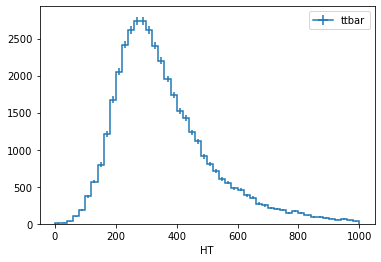

In [8]:
output[0].plot(label="ttbar")
plt.legend();